# Gathering the player ratings data - File in early stages

# Scanning Data

In [46]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf

In [48]:
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

In [49]:
pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [47]:
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv('game_ratings.csv')

In [9]:
df.head()

,game_id,user,rating
0,1,jackcres,10.0
1,1,FuManchu,10.0
2,1,HankM,10.0
3,1,jonnypolite,10.0
4,1,pwotruba,10.0


In [60]:
num_ratings = pd.pivot_table(df, index=['user'], values=['rating'], aggfunc='count')
num_ratings.reset_index(inplace=True)
num_ratings.columns = ['user','ratings']
num_ratings.sort_values('ratings', ascending=False).head(10)

,user,ratings
282439,stoneart69,377
271005,ryansmum2008,375
36706,Doel,375
66153,JasonSaastad,374
106101,Pandorzecza,373
52633,Gibmaatsuki,372
233284,leffe dubbel,372
297318,we3die,361
295537,vincivader,350
259357,pete100,348


In [63]:
num_ratings[num_ratings['ratings'] > -1].shape[0], num_ratings[num_ratings['ratings'] > 10].shape[0]

(304441, 108991)

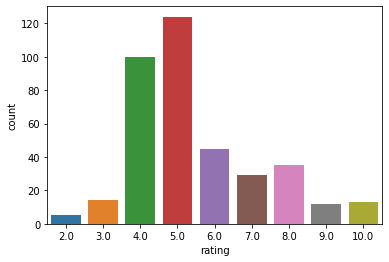

In [18]:
sns.countplot(data=df[df['user'] == 'stoneart69'], x = 'rating')

In [30]:
df['rating_int'] = df['rating'].astype(int)

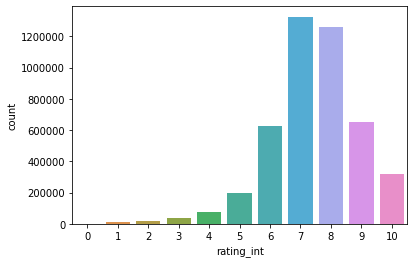

In [31]:
sns.countplot(data = df, x = 'rating_int')

In [35]:
df['approve'] = np.where(df['rating'] >= 7, 1, 0)

In [39]:
pivot.head()

,user,ratings
0,beastvol,3
1,mycroft,4
2,woh,2
3,-=Yod@=-,68
4,-Johnny-,57


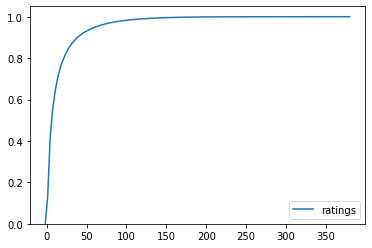

In [41]:
sns.kdeplot(pivot['ratings'], cumulative=True)

In [45]:
pivot[pivot['ratings'] <= 20].shape[0], pivot[pivot['ratings'] > 20].shape[0]

(241518, 62923)

# Recommender System

In [50]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [69]:
ratings = df.merge(num_ratings, on ='user')
ratings = ratings[ratings['ratings'] > 10]
ratings.head()

,game_id,user,rating,rating_int,approve,ratings
0,1,jackcres,10.0,10,1,31
1,1035,jackcres,8.0,8,1,31
2,1041,jackcres,8.0,8,1,31
3,11,jackcres,6.0,6,0,31
4,110327,jackcres,6.0,6,0,31


In [137]:
from collections import defaultdict

def return_negative_one():
    return -1
    
user_dict = defaultdict(return_negative_one)
game_dict = defaultdict(return_negative_one)

In [138]:
i = 0
for u in ratings['user'].unique():
    user_dict[u] = i
    i += 1

In [139]:
i = 0
for u in ratings['game_id'].unique():
    game_dict[u] = i
    i += 1

In [140]:
ratings['user_idx'] = ratings['user'].apply(lambda x: user_dict[x])
ratings['game_idx'] = ratings['game_id'].apply(lambda x: game_dict[x])
ratings.head()

,game_id,user,rating,rating_int,approve,ratings,user_idx,game_idx
0,1,jackcres,10.0,10,1,31,0,0
1,1035,jackcres,8.0,8,1,31,0,1
2,1041,jackcres,8.0,8,1,31,0,2
3,11,jackcres,6.0,6,0,31,0,3
4,110327,jackcres,6.0,6,0,31,0,4


In [141]:
ratings.dtypes

game_id         int64
user           object
rating        float64
rating_int      int32
approve         int32
ratings         int64
user_idx        int64
game_idx        int64
dtype: object

In [142]:
ratings.shape[0], ratings['user_idx'].max(), ratings['user_idx'].nunique()

(3801461, 108990, 108991)

In [143]:
#@title Solution
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_idx', 'game_idx']].values
  values_ = ratings_df['rating_int'].values
  return tf.SparseTensor(
      indices=indices,
      values=values_,
      dense_shape=[ratings_df['user_idx'].nunique(), ratings_df['game_idx'].nunique()])

In [144]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [145]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [146]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_idx": U,
      "game_idx": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [147]:
train_ratings, test_ratings = split_dataframe(ratings)
# SparseTensor representation of the train and test datasets.
A_train = build_rating_sparse_tensor(train_ratings)
A_test = build_rating_sparse_tensor(test_ratings)

 iteration 300: train_error=6.967058, test_error=7.65672287

[{'train_error': 6.967058, 'test_error': 7.656722}]

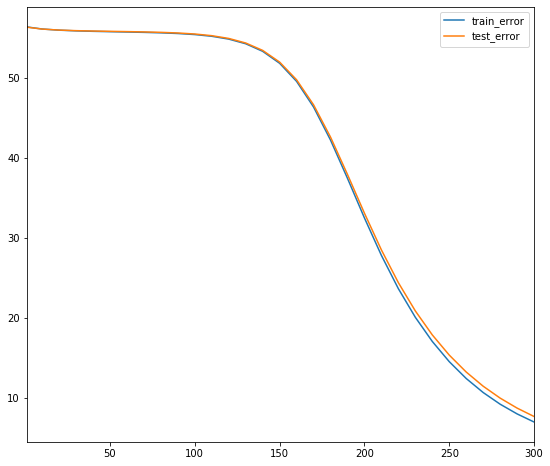

In [148]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=10, init_stddev=0.5)
model.train(num_iterations=300, learning_rate=10.)

In [149]:
#itle Solution
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [150]:
import sqlite3
con = sqlite3.connect('bgg.db')
cur = con.cursor()

In [151]:
#results = cur.execute('SELECT * FROM TOP_GAMES_FULL')
results = cur.execute('PRAGMA table_info(TOP_GAMES_FULL)')
results = results.fetchall()
result_li = [r for r in results]
column_li = []
for r in result_li:
    column_li.append(r[1])

print(column_li)

['id', 'title', 'year', 'min_players', 'max_players', 'avg_rating', 'avg_bayes_rating', 'std', 'ratings', 'weight', 'play_time']


In [152]:
results = cur.execute('SELECT * FROM TOP_GAMES_FULL')
results = results.fetchall()
result_li = [r for r in results]
df = pd.DataFrame(result_li, columns = column_li)
df.head()

,id,title,year,min_players,max_players,avg_rating,avg_bayes_rating,std,ratings,weight,play_time
0,174430,gloomhaven,2017,1,4,8.76798,8.53089,1.63005,45304,3.8673,120
1,161936,pandemic_legacy_season_1,2015,2,4,8.60479,8.45273,1.56467,43525,2.836,60
2,224517,brass_birmingham,2018,2,4,8.66929,8.406,1.24659,22694,3.9084,120
3,167791,terraforming_mars,2016,1,5,8.4247,8.27852,1.38438,69921,3.244,120
4,291457,gloomhaven_jaws_lion,2020,1,4,8.7573,8.2579,1.40857,12633,3.559,120


In [156]:
df['game_idx'] = df['id'].apply(lambda x: game_dict[int(x)])
games = df[df['game_idx'] >= 0]
games = games[['game_idx', 'title', 'year', 'weight', 'play_time']]

In [210]:
def game_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  games.loc[games['title'].str.contains(title_substring), ['game_idx']].values
  ids = list(ids.flatten())
  titles = games.loc[games['game_idx'].isin(ids), 'title'].values
  if len(titles) == 0:
    raise ValueError("Found no games with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching game. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["game_idx"][movie_id], model.embeddings["game_idx"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': games['title']
      #'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [221]:
game_neighbors(model, "lords_waterdeep", COSINE)

Nearest neighbors of : lords_waterdeep.


,cosine score,titles
8,1.000000,through_ages_new_story_civilization
293,0.999981,evolution_climate
97,0.999960,codenames
299,0.999928,die_macher
303,0.999927,sale
365,0.999924,flash_point_fire_rescue


In [215]:
game_neighbors(model, "among_stars", DOT)

Nearest neighbors of : among_stars.


,dot score,titles
646,84.829483,among_stars
99,84.319702,roll_galaxy
59,82.737221,android_netrunner
581,80.401123,vegas_showdown
15,80.139221,7_wonders_duel
466,80.063660,port_royal


roll_player
['skull_king']
Nearest neighbors of : skull_king.


,cosine score,titles
521,1.000000,skull_king
965,0.998387,vikings_gone_wild
602,0.998385,onirim_second_edition
435,0.997989,sentinels_multiverse
759,0.997951,dale_merchants
913,0.997790,china


In [178]:
game_neighbors(model, "7_wonders_duel", DOT)

Nearest neighbors of : orleans.


,dot score,titles
646,100.963379,among_stars
99,100.298355,roll_galaxy
59,98.462547,android_netrunner
581,95.723923,vegas_showdown
15,95.437363,7_wonders_duel
466,95.265923,port_royal


In [170]:
games[games['title'].str.contains('coup')]

,game_idx,title,year,weight,play_time
522,99,coup,2012,1.4057,15


# Scratch Code

In [ ]:
# from __future__ import print_function

# import numpy as np
# import pandas as pd
# import collections
# from mpl_toolkits.mplot3d import Axes3D
# from IPython import display
# from matplotlib import pyplot as plt
# import sklearn
# import sklearn.manifold
# import tensorflow.compat.v1 as tf

# # Install Altair and activate its colab renderer.
# print("Installing Altair...")
# !pip install git+git://github.com/altair-viz/altair.git
# import altair as alt
# alt.data_transformers.enable('default', max_rows=None)
# alt.renderers.enable('colab')
# print("Done installing Altair.")

# # Install spreadsheets and import authentication module.
# USER_RATINGS = False
# !pip install --upgrade -q gspread
# from google.colab import auth
# import gspread
# from oauth2client.client import GoogleCredentials